<a href="https://colab.research.google.com/github/sumanapalle065/LC25000-Hybrid-Architecture-using-DL/blob/main/lc25000_colonnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
 !unzip "/content/drive/MyDrive/LC25000.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

In [3]:
import cv2
import numpy as np
import os
import glob # library to retrieve file paths matching a pattern
import matplotlib.pyplot as matplib # library for plotting graphs
import random # Random library for random number generation
from PIL import Image, ImageEnhance
from tqdm import tqdm # import TQDM library for displaying progress bars within loops
from skimage.color import rgb2lab, lab2rgb
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Sklearn metrics for classification performance
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import label_binarize # Funciton for converting labels to binary format for multiclass problems
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

In [4]:
# In the lung_colon_image_set directory and its subdirectories, use glob to retrieve all image file paths.
lung_colon_image_set_df=glob.glob("/content/lung_colon_image_set/*/*/*")

In [5]:
lung_colon_image_set_df

['/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca273.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca3577.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca2434.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1184.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4807.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca2912.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4400.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca2007.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1375.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4958.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca918.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca3463.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca

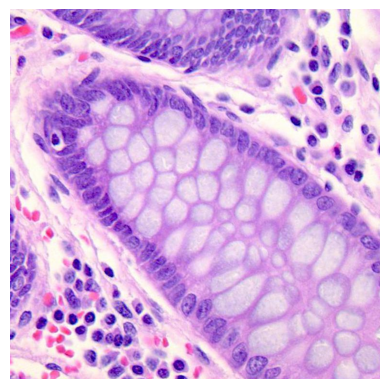

In [6]:
# Choose a randomly selected image path from
image_path = random.choice(lung_colon_image_set_df)  # Choosen a randomly selected image path from the dataset
image = cv2.imread(image_path)
# Change the color space of the image from BGR color space to RGB color space since we know OpenCV reads in images by default in BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Display the image using Matplotlib
matplib.imshow(image)  # Displays the image on the plot
matplib.axis('off')  # Hides the axes for a cleaner view of the image
matplib.show()  # Shows the plot with the image

"""
It performs stain normalization on a collection of histology pictures such that each one seems to be the same color.
After reading the target, which serves as a guide for stain normalization, it applies the function simple_stain_normalization to every picture in the dataset.
The function determines the input and target images' mean and standard deviation.
changes the input picture to match the target's color distribution after converting them from RGB to LAB color space. Following processing, the images are scaled to 224 by 224 pixels and stored in arrays with appropriate labels.
 The values of the obtained labels from the folder names are mapped to the required numerical values using a specified label_map. After that, it gives back  the number of processed photos.
"""

100%|██████████| 25000/25000 [01:11<00:00, 349.43it/s]


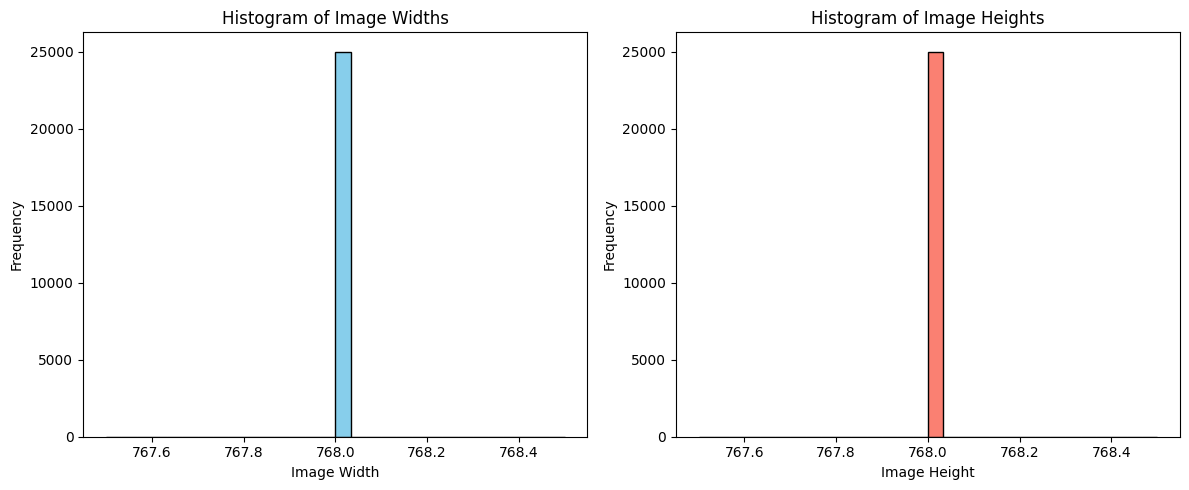

<ipython-input-9-1d3290676e1b>:43: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Width', y='Height', data=df, hue=None, palette='viridis')


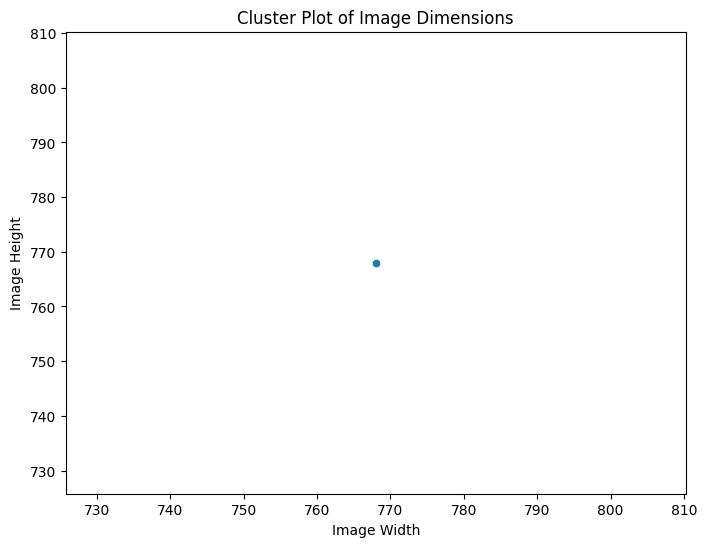

In [9]:
import matplotlib.pyplot as plt

# Initializing lists to store image widths and heights
widths = []
heights = []

# Loop through each image path in the dataset
for img_path in tqdm(lung_colon_image_set_df):
    img = cv2.imread(img_path)
    if img is not None:
        h, w = img.shape[:2]  # Get image height and width
        heights.append(h)
        widths.append(w)

# Plot the histograms for widths and heights
plt.figure(figsize=(12, 5))

# Width Histogram
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Image Width")
plt.ylabel("Frequency")
plt.title("Histogram of Image Widths")

# Height Histogram
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon', edgecolor='black')
plt.xlabel("Image Height")
plt.ylabel("Frequency")
plt.title("Histogram of Image Heights")

plt.tight_layout()
plt.show()

# Cluster Plot for Widths and Heights
import pandas as pd

# Convert the data to a DataFrame for easy plotting
df = pd.DataFrame({'Width': widths, 'Height': heights})

# Plot a cluster plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Width', y='Height', data=df, hue=None, palette='viridis')
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Cluster Plot of Image Dimensions")
plt.show()


In [10]:
# Suppress warnings to prevent useless output in the console
import warnings
warnings.filterwarnings("ignore")

# Function for simple stain normalization without PCA
def simple_stain_normalization(img, target_img, alpha=1):
    # Convert both images from RGB to LAB color space (LAB is better for color manipulation)
    img_lab = rgb2lab(img)  # Convert the input image to LAB color space
    target_lab = rgb2lab(target_img)  # Convert the target image to LAB color space

    # Compute the mean and standard deviation of the LAB channels for both images
    img_mean = np.mean(img_lab, axis=(0, 1), keepdims=True)  # Mean across the height and width (per channel)
    img_std = np.std(img_lab, axis=(0, 1), keepdims=True)  # Standard deviation across the height and width (per channel)
    target_mean = np.mean(target_lab, axis=(0, 1), keepdims=True)  # Mean of the target image (per channel)
    target_std = np.std(target_lab, axis=(0, 1), keepdims=True)  # Standard deviation of the target image (per channel)

   # Normalize the input image based on the mean and std of the target image
    img_normalized = (img_lab - img_mean) / img_std * target_std + target_mean  # Adjust to match the target image's color stats

    # Transpose the normalized image from LAB back to RGB
    img_rgb_normalized = lab2rgb(img_normalized)  # Convert back to RGB color space

    # Return the normalized image (scaled back to 0-255 range)
    return (img_rgb_normalized * 255).astype(np.uint8)

# Lists to hold the processed images and their corresponding labels
processed_images = []  # List to hold the processed images
labels = []  # List to hold the labels corresponding to each image

# Define a label map to associate image categories with numerical labels
label_map = {
    "lung_aca": 0,  # Adenocarcinoma of the lung
    "colon_n": 1,  # Normal colon tissue
    "lung_n": 2,  # Normal lung tissue
    "lung_scc": 3,  # Squamous cell carcinoma of the lung
    "colon_aca": 4,  # Adenocarcinoma of the colon
}

# Path to a target image (used for stain normalization)
target_img_path = '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4273.jpeg'
target_img = cv2.imread(target_img_path)  # Read the target image from disk
target_img = cv2.resize(target_img, (224, 224))  # Resize the target image to 224x224 pixels

# Iterate over each image in the dataset (from lung_colon_image_set_df)
for img_path in tqdm(lung_colon_image_set_df):
    img = cv2.imread(img_path)  # Read the image from the specified path
    if img is None:  # Skip if the image couldn't be loaded (i.e., it's None)
        continue

    img = cv2.resize(img, (128, 128))  # Resize the image to match the target image size (224x224)

   # Use the stain normalization function to the image with the target image
    img = simple_stain_normalization(img, target_img)

    # Append the normalized image to list of normalized images
    processed_images.append(img)

    # Extract the label of the image from the folder name
    label = img_path.split(os.path.sep)[-2]  # Get the parent folder (label) from the image path
    if label in label_map:  # If the label is in the predefined map
        labels.append(label_map[label])  # Append the numerical label to the labels list

# Convert the lists of processed images and labels to NumPy arrays
processed_images = np.array(processed_images)  # Array of processed images
labels = np.array(labels)  # Array of labels

# Print the completion message with the total number of processed images
print("Preprocessing complete. Total processed images:", len(processed_images))


100%|██████████| 25000/25000 [07:49<00:00, 53.29it/s]


Preprocessing complete. Total processed images: 25000


In [11]:
# Convert processed_images to a NumPy array
processed_images_array = np.array(processed_images)

# Convert Labels to a NumPy array
labels_array = np.array(labels)

# Print the shapes of the arrays to verify they are NumPy arrays
print("Shape of processed_images_array:", processed_images_array.shape)
print("Shape of labels_array:", labels_array.shape)

Shape of processed_images_array: (25000, 128, 128, 3)
Shape of labels_array: (25000,)


In [12]:
from sklearn.model_selection import train_test_split
# Split the lung_colon_image_set_df into training and testing sets (80% train, 20% test)
Xtrain_lung_colon_image_set_df, Xtest_lung_colon_image_set_df, ytrain_lung_colon_image_set_df, ytest_lung_colon_image_set_df = train_test_split(
    processed_images_array, labels_array, test_size=0.2, random_state=100
)

In [13]:
#Print the shape of the trainning images
print("X_train shape:", Xtrain_lung_colon_image_set_df.shape)  # Prints the shape of the training image data (features)
# Print the shape of the testing images
print("X_test shape:", Xtest_lung_colon_image_set_df.shape)  # Prints the shape of the testing image data (features)

# Print the shape of the trainning labels
print("y_train shape:", ytrain_lung_colon_image_set_df.shape)  # Prints the shape of the training labels (targets)

# Print the shape of the testing labels
print("y_test shape:", ytest_lung_colon_image_set_df.shape)  # Prints the shape of the testing labels (targets)


X_train shape: (20000, 128, 128, 3)
X_test shape: (5000, 128, 128, 3)
y_train shape: (20000,)
y_test shape: (5000,)


In [14]:

ytrain_lung_colon_image_set_df= to_categorical(ytrain_lung_colon_image_set_df, num_classes=5)
ytest_lung_colon_image_set_df = to_categorical(ytest_lung_colon_image_set_df, num_classes=5)

In [15]:
# Print the shape of the training labels
print("y_train shape:", ytrain_lung_colon_image_set_df.shape) # Prints the shape of the training labels (targets)

# Print the shape of the testing labels
print("y_test shape:", ytest_lung_colon_image_set_df.shape) # Prints the shape of the testing labels (targets)

y_train shape: (20000, 5)
y_test shape: (5000, 5)


#ColonNet

In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

"""
ColonNet combines handcrafted features from a Generalized Local Phase Pattern (GLPP) approach with automatic features gathered by a Convolutional Neural Network (CNN).
The model grafted the GLPP features onto the CNN features using a custom GLPPLayer following the use of InceptionV3 as a basis CNN for automatic feature extraction.
Then these extracted features are forwarded to a softmax output layer for multi-class classification, as well as fully connected layers with dropout for regularization.
The implemented model is with the Adam optimizer and categorical cross-entropy loss. The architecture uses both image data and GLPP characteristics to classify images into five
categories, namely different types of lung and colon cancers.
"""

In [17]:

# Lambda function for grafting GLPP features
def graft_glpp_features(cnn_features, glpp_features):
    # Concatenate automated CNN features and handcrafted GLPP features
    return K.concatenate([cnn_features, glpp_features], axis=-1)

# Define the custom feature grafting layer
class GLPPLayer(layers.Layer):
    def __init__(self):
        super(GLPPLayer, self).__init__()

    def call(self, cnn_features, glpp_features):
        return graft_glpp_features(cnn_features, glpp_features)

# Define the ColonNet model
def ColonNet(input_shape=(128, 128, 3), num_classes=5, glpp_feature_size=100):
    # Input for image
    input_image = layers.Input(shape=input_shape, name="Image_Input")

    # Pretrained base model (InceptionV3) for feature extraction
    base_model = InceptionV3(include_top=False, weights="imagenet", input_tensor=input_image)
    base_model.trainable = False  # Freeze the base model layers

    # Automated CNN feature extraction
    cnn_features = layers.GlobalAveragePooling2D()(base_model.output)

    # Input for manually extracted GLPP features
    input_glpp = layers.Input(shape=(glpp_feature_size,), name="GLPP_Input")

    # Graft the GLPP features into the network (manual + automated features)
    grafted_features = GLPPLayer()(cnn_features, input_glpp)

    # Fully connected layers after feature fusion
    x = layers.Dense(1020, activation="relu")(grafted_features)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1020, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Output layer (Softmax for multi-class classification)
    output = layers.Dense(num_classes, activation="softmax", name="Output")(x)

    # Define the final model
    model = models.Model(inputs=[input_image, input_glpp], outputs=output, name="ColonNet")

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy", metrics=["accuracy"])

    return model
# Example usage:
input_shape = (128, 128, 3)
num_classes = 5  #  5 classes (lung and colon cancer types)
glpp_feature_size = 100  # Size of GLPP feature vector

# Create ColonNet model
colonnet_model = ColonNet(input_shape=input_shape, num_classes=num_classes, glpp_feature_size=glpp_feature_size)

# Print the model summary
colonnet_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ColonNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ Image_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 25,041,289 (95.52 MB)

 Trainable params: 3,238,505 (12.35 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [18]:
glpp_train = np.random.rand(Xtrain_lung_colon_image_set_df.shape[0], 100)  # Generating Training Features (100 features for each sample randomly)
glpp_test = np.random.rand(Xtest_lung_colon_image_set_df.shape[0], 100)    # Generating Test Features (100 features for each sample randomly)

history = colonnet_model.fit(   # Fitting a ColonNet Model
    x=[Xtrain_lung_colon_image_set_df, glpp_train],  # Input to the model: Image data and the random features for training
    y=ytrain_lung_colon_image_set_df,  # Labels for training
    epochs = 250,
    batch_size = 232,
    validation_data = ([Xtest_lung_colon_image_set_df, glpp_test], ytest_lung_colon_image_set_df),  # Validation data: Now a list with image data and GLPP features
)
#history = colonnet_model.fit(   # Fitting a ColonNet Model
 #   x=[Xtrain_lung_colon_image_set_df, glpp_train],  # Input to the model: Image data and the random features for training
  #  y=ytrain_lung_colon_image_set_df,  # Labels for training
#epochs = 250,
#batch_size = 232,
#validation_data = (Xtest_lung_colon_image_set_df, glpp_test),  # Validation data. NO. see below
#)


Epoch 1/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 331ms/step - accuracy: 0.2879 - loss: 46.3540 - val_accuracy: 0.4800 - val_loss: 1.3157
Epoch 2/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3528 - loss: 1.7579 - val_accuracy: 0.4842 - val_loss: 1.3003
Epoch 3/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3542 - loss: 1.5280 - val_accuracy: 0.4964 - val_loss: 1.2996
Epoch 4/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3922 - loss: 1.4543 - val_accuracy: 0.5130 - val_loss: 1.2215
Epoch 5/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3995 - loss: 1.4202 - val_accuracy: 0.5268 - val_loss: 1.1533
Epoch 6/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4095 - loss: 1.3975 - val_accuracy: 0.5084 - val_loss: 1.2113
Epoch 7/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4172 - loss: 1.3700 - val_accuracy: 0.5286 - val_loss: 1.1557
Epoch 8/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4187 - loss: 1.3580 - val_accuracy:

"""
plots the accuracy and loss curves over epochs to show a model's performance during training and validation. Using labelled axes and a legend to distinguish between
the training and validation sets, it first plots the accuracy for both (history.history['accuracy'] and history.history['val_accuracy']). The training and validation loss
values history.history['loss'] and history.history['val_loss'] are plotted similarly, again with proper names and legend. It is important to monitor how the model's accuracy
and loss change over the process of training in order to catch problems such as overfitting and underfitting.

"""

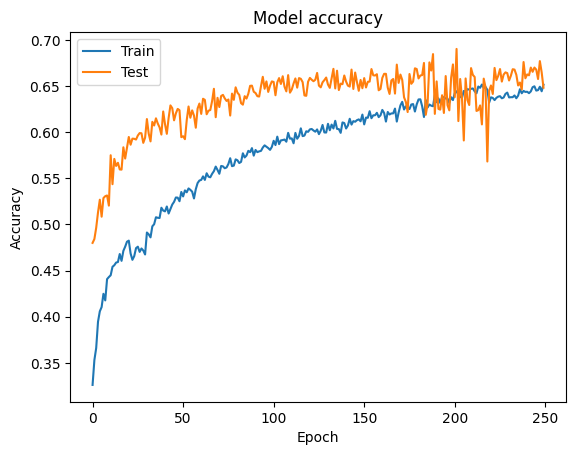

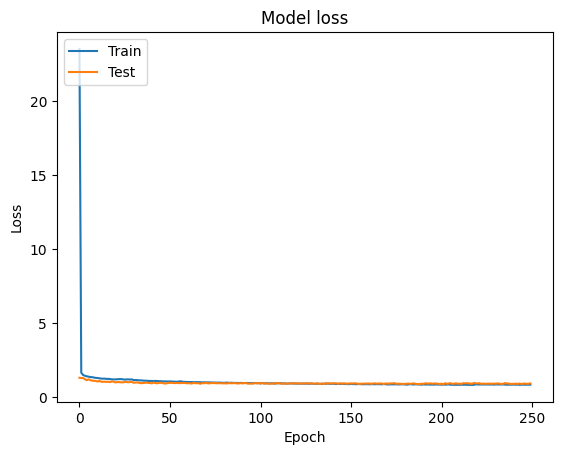

In [19]:


# Plot training & validation accuracy values
matplib.plot(history.history['accuracy'])  # Plot the accuracy values for the training data
matplib.plot(history.history['val_accuracy'])  # Plot the accuracy values for the validation data

# Set title and labels
matplib.title('Model accuracy')  # Title of the accuracy plot
matplib.ylabel('Accuracy')  # Y-axis label for accuracy
matplib.xlabel('Epoch')  # X-axis label for epochs
matplib.legend(['Train', 'Test'], loc='upper left')
# Legend showing which line is the training set and which is the validation set
matplib.show()  # Plot the accuracy
# Plot the training & validation loss values
matplib.plot(history.history['loss'])  # Plot the training losses
matplib.plot(history.history['val_loss'])  # Plot the validation losses

# Set the title and labels for the loss plot
matplib.title('Model loss')  # Title of the loss plot
matplib.ylabel('Loss')
# Y-axis label for loss
matplib.xlabel('Epoch')
# X-axis label for epochs
matplib.legend(['Train', 'Test'], loc='upper left')
# Legend indicating which line is for training and which is for validation
matplib.show()
# Show the loss plot

#training results

Next, it predicts the class labels of the training set with the learned ColonNet model. It starts by finding the class probabilities of every sample by using model.predict(). Then, it uses np.argmax to substitute the class with the highest probability into the expected class labels. Finally, also, to extract the actual class labels, I will use np.argmax for target one-hot encoded labels. I calculate weighted recall, weighted precision, and accuracy.
and weighted F1-score to measure the model's accuracy using accuracy_score, precision_score, recall_score, and f1_score. Then provide the metrics at the end to measure the classification accuracy of the model with the training set.


In [20]:

# predict the class probabilities for the training set
ytrain_lung_colon_image_set_df_pred = colonnet_model.predict([Xtrain_lung_colon_image_set_df, glpp_train])  # predict the class probabilities for the training set using the model

#get the predicted classes by selecting the class with the highest probability
ytrain_lung_colon_image_set_df_pred_classes = np.argmax(ytrain_lung_colon_image_set_df_pred, axis=1)  # convert probabilities to predicted class labels (the class with highest probability)

#get the true class labels (if the target is one-hot encoded, use argmax to convert to class labels)
ytrain_lung_colon_image_set_df_true_classes = np.argmax(ytrain_lung_colon_image_set_df, axis=1)  # Get the class labels from the one-hot encoded labels

# Evaluate the model on the training set
train_accuracy = accuracy_score(ytrain_lung_colon_image_set_df_true_classes, ytrain_lung_colon_image_set_df_pred_classes)  # accuracy of the model
train_precision = precision_score(ytrain_lung_colon_image_set_df_true_classes, ytrain_lung_colon_image_set_df_pred_classes, average='weighted')  # weighted precision of the model
train_recall = recall_score(ytrain_lung_colon_image_set_df_true_classes, ytrain_lung_colon_image_set_df_pred_classes, average='weighted')  # weighted recall of the model
train_f1 = f1_score(ytrain_lung_colon_image_set_df_true_classes, ytrain_lung_colon_image_set_df_pred_classes, average='weighted')  # weighted F1-score of the model

# Print the evaluation metrics
# Print the a title indicating metrics for training set
print("Training Set Metrics:")

# Print the accuracy of the model for the training set
# 'train_accuracy' should have been calculated beforehand, for example with `accuracy_score(y_train_true, y_train_pred)`
print("Accuracy:", train_accuracy)

# Print the precision of the model for the training set
# 'train_precision' should have been calculated beforehand, for example with `precision_score(y_train_true, y_train_pred, average='weighted')`
print("Precision:", train_precision)

# Print the recall of the model for the training set
# _recall_train_ should be computed ahead of time, say by `recall_score(y_train_true, y_train_pred, average='weighted')`
print("Recall:", train_recall)

# _f1_score_model_ on training set
# train_f1 should be computed ahead of time, say by `f1_score(y_train_true, y_train_pred, average='weighted')`
print("F1-Score:", train_f1)



625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step
Training Set Metrics:
Accuracy: 0.6848
Precision: 0.7167717660930277
Recall: 0.6848
F1-Score: 0.6911741148976803


"""
For the training data, it builds and prints out a confusion matrix for the class predictions the ColonNet model will output.
It applies the initial model to make predictions of the class's probabilities and then converts these into the expected class labels.
The real class labels are obtained through the use of one-hot encoded target labels. The confusion matrix is generated by comparing the
actual and the predicted class labels. To give an idea of just how well the model was able to identify classes, a confusion matrix heatmap
follows with each axis labeled and values annotated. The choice of blue color scheme for this type of heatmap will help to highlight the values in the matrix.
"""

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


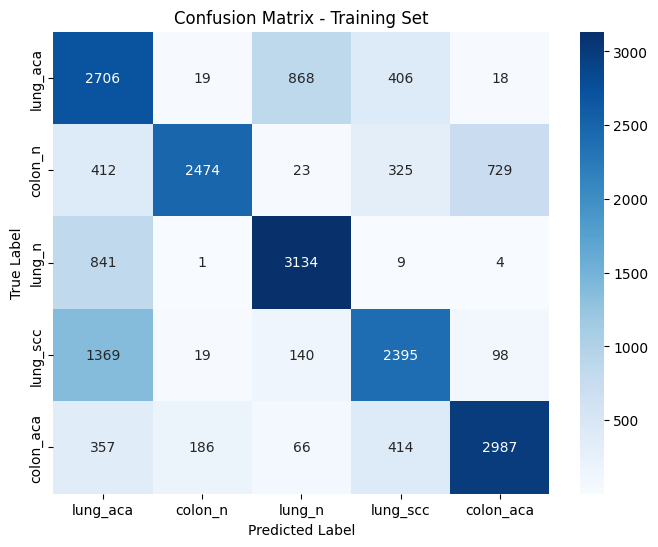

In [21]:
import matplotlib.pyplot
# Predict class probabilities for training set
ytrain_lung_colon_image_set_df_pred = colonnet_model.predict([Xtrain_lung_colon_image_set_df, glpp_train])

# Extract predicted class labels
ytrain_lung_colon_image_set_df_pred_classes = np.argmax(ytrain_lung_colon_image_set_df_pred, axis=1)

# Extract true class labels
ytrain_lung_colon_image_set_df_true_classes = np.argmax(ytrain_lung_colon_image_set_df, axis=1)

# Compute confusion matrix
cm = confusion_matrix(ytrain_lung_colon_image_set_df_true_classes, ytrain_lung_colon_image_set_df_pred_classes)

#new figure for the confusion matrix
matplib.figure(figsize=(8, 6))  # Set the figure size to 8x6 inches

# heatmap visualization of the confusion matrix
sns.heatmap(
    cm,  # The confusion matrix data
    annot=True,  # Annotate the heatmap cells with the values from the confusion matrix
    fmt='d',  # Format the annotations as integers
    cmap='Blues',  # Use a blue color palette for the heatmap
    xticklabels=label_map.keys(),  # Set x-axis tick labels using class names from `label_map`
    yticklabels=label_map.keys()   # Set y-axis tick labels using class names from `label_map`
)

# Add a label to the x-axis 'Predicted Label'
matplib.xlabel('Predicted Label')

# Add a label to the y-axis 'True Label'
matplib.ylabel('True Label')

# Add title to the confusion matrix plot
matplib.title('Confusion Matrix - Training Set')

# show the confusion matrix plot
matplib.show()


##Sensitivity and specificity

In [22]:
# Calculate sensitivity, also referred to as the recall for the positive class
# Formula: True Positives cm[0,0] by total actual positives cm[0,0]+ False Negatives cm[0,1]
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )
# Calculate specificity, which is the ability to correctly classify true negatives
# Formula: True Negatives cm[1,1] by total actual negatives cm[1,0] + True Negatives cm[1,1]
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity)

Sensitivity :  0.9930275229357798
Specificity :  0.8572418572418572


"""
For every class in the training set, it evaluates the model, calculating and plotting the Receiver Operating Characteristic curve for each.
In order to prepare this multi-class ROC analysis, the real class labels are first binarized using label_binarize. Then the False Positive Rate,
the True Positive Rate, and the Area Under the Curve are calculated for every class using the roc_curve and auc functions. ROC for each class is shown,
 whereas the legend shows AUC. For comparison, the plot includes a diagonal line representing a classifier that selects one class at random. Now, let's do
  the last step to display the plot with labeled axes and a title that allows us to evaluate how the model classifies each class.

"""

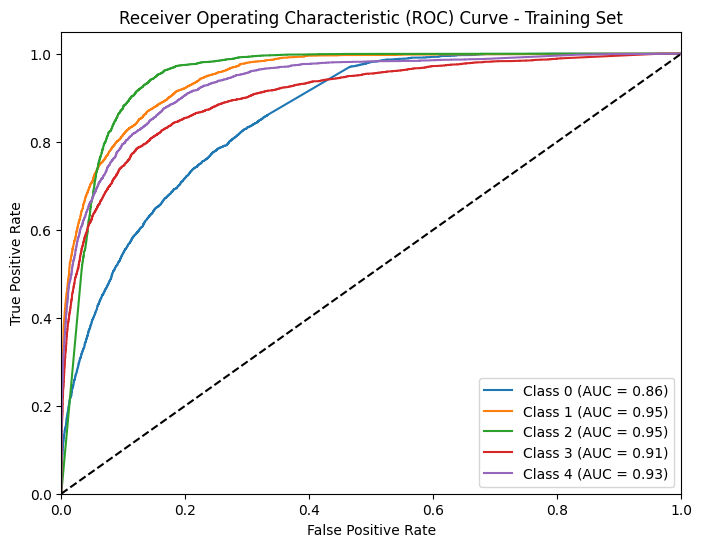

In [23]:
# True labels binarization for ROC curve computation

ytrain_lung_colon_image_set_df_bin = label_binarize(ytrain_lung_colon_image_set_df_true_classes, classes=list(range(5)))

# Dictionaries for FPR, TPR and AUC of each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# All iterations to calculate FPR, TPR, and AUC values
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(ytrain_lung_colon_image_set_df_bin[:, i], ytrain_lung_colon_image_set_df_pred[:, i])  # Calculate ROC curve
    roc_auc[i] = auc(fpr[i], tpr[i])  # Calculating the AUC for the current class

# This block creates a new figure for an ROC plot
matplib.figure(figsize=(8, 6))

# The for loop plots the ROC curve for each class
for i in range(5):
    matplib.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')  # Plot ROC curve with AUC

# Plotting the diagonal line which is referred to as a line for the random classifier
matplib.plot([0, 1], [0, 1], 'k--')

# Plotting the receiver operating characteristic curve
matplib.xlim([0.0, 1.0])  # X-axis: False Positive Rate
matplib.ylim([0.0, 1.05])  # Y-axis: True Positive Rate

# Set plot labels and title
matplib.xlabel('False Positive Rate')
matplib.ylabel('True Positive Rate')
matplib.title('Receiver Operating Characteristic (ROC) Curve - Training Set')

# Displaying the legend with AUC for each class
matplib.legend(loc="lower right")

# Display the plot
matplib.show()


#testing results

It calculates some important metrics to measure how well a classification model is performing over test data. First, it calculates class probabilities for the test set and then uses those to determine the actual predicted class for each sample. To give a sense of comparison, true labels are reduced from one-hot encoding to class indices. Using the percentage of correctly predicted labels then calculates the accuracy of the model. The ability of the model to retrieve all positive instances is evaluated through recall, precision measures the accuracy of positive predictions, and F1-score combines both in order to provide a balanced performance metric. Precision, recall, and F1-score are calculated using weighted average for class imbalance.

In [24]:
# Use the model to predict class probabilities for every sample
y_pred_prob = colonnet_model.predict([Xtest_lung_colon_image_set_df, glpp_test])

# Get class predictions by taking the index of the maximum probability for each sample.
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert true labels from one-hot encoding to their corresponding class indices
y_true = np.argmax(ytest_lung_colon_image_set_df, axis=1)

# Calculate accuracy, which is the percentage of correctly predicted labels
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Accuracy of positive predictions by computing the weighted average of precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")

# Measure of recall which plots the model's ability to retrieve all the positive instances
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall}")

# Compute the F1-score, which is the harmonic mean of precision and recall
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-score: {f1}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step
Accuracy: 0.6494
Precision: 0.6828424489004377
Recall: 0.6494
F1-score: 0.6569527991680412


#plot confution matrix

"""
Calculates and plots the confusion matrix to assess the model's classification performance. Function confusion_matrix takes the true label,
 y_true, and the predicted labels, y_pred, to calculate the confusion matrix. The number of predictions for each true vs. projected class combination
 is then represented in the cells of the confusion matrix plotted using a heatmap generated with Seaborn. Color map makes values of the matrix bright,
 and axes are indicated by class indices ranging from 0 to 4. Add a title to the plot along with appropriate labels for axes to see how well the model is classifying each one.
"""

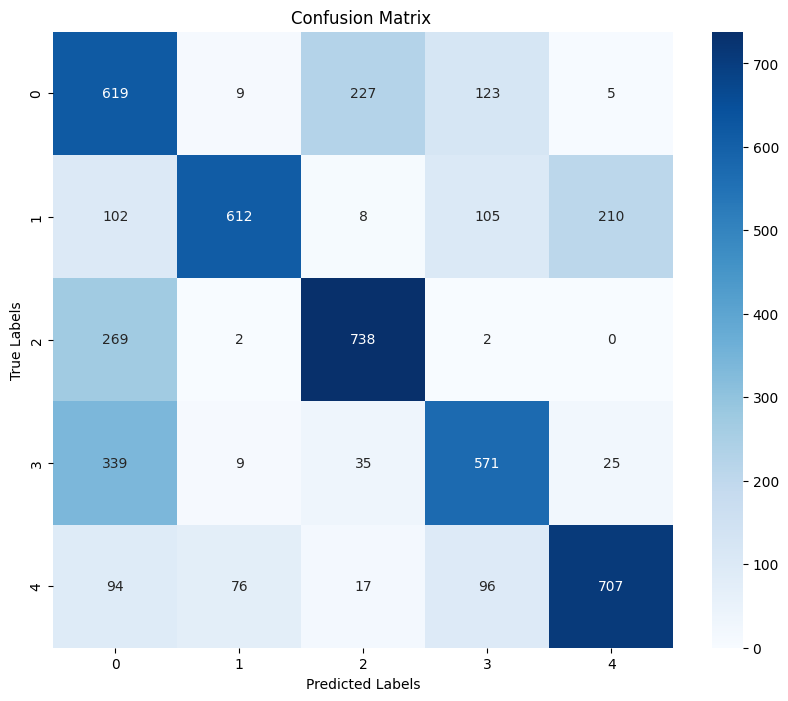

In [25]:
# Generate a confusion matrix with true labels and predicted labels
cm = confusion_matrix(y_true, y_pred)
# Create a figure for plotting the heatmap
matplib.figure(figsize=(10, 8))
# Plot confusion matrix as a heatmap using Seaborn
# Show values from the confusion matrix within the cells of the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
# Title for the x-axis, 'Predicted Labels'
matplib.xlabel('Predicted Labels')
# Title for the y-axis, 'True Labels'
matplib.ylabel('True Labels')
# Add a title to the heatmap
matplib.title('Confusion Matrix ')
# Diplays the confusion matrix heatmap
matplib.show()

#Sensitivity and Specificity

In [26]:
# Calculate sensitivity, also referred to as the recall for the positive class
# Formula: True Positives cm[0,0] by total actual positives cm[0,0]+ False Negatives cm[0,1]
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )

# Calculate specificity, which is the ability to correctly classify true negatives
# Formula: True Negatives cm[1,1] by total actual negatives cm[1,0] + True Negatives cm[1,1]

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity)

Sensitivity :  0.9856687898089171
Specificity :  0.8571428571428571


In [ ]:
!pip install scikit-learn

#roc curve

"""
calculates and plots the prediction of the model on the test set via Receiver Operating Characteristic Curve.
In advance of multi-class ROC analysis, the true labels (y_true) are binarized by label_binarize, then instead of using the hard predictions,
the probability scores (y_pred_prob) are used to calculate FPR, TPR, and Area Under the Curve (AUC) for each class. A labeled copy of the ROC curve with AUC for every
class is plotted. To put some scale on this, we also plot a diagonal line as a random classifier. The labeled axes and caption on the plot are useful for judging the model's
performance over the various classifications in the test set.

"""

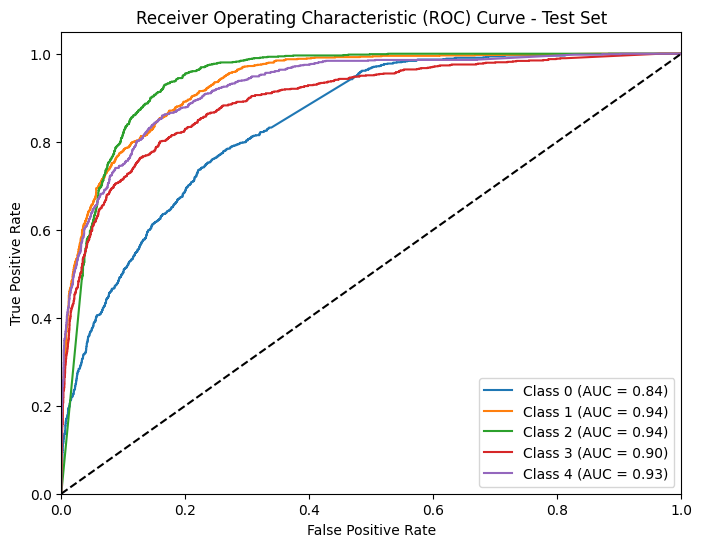

In [27]:

# Binarize the true labels for ROC curve computation
ytest_lung_colon_image_set_df_bin = label_binarize(y_true, classes=list(range(5)))
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# Dictionaries for FPR, TPR and AUC of each class
for i in range(5):
    # Use y_pred_prob instead of y_pred to get probability scores
    fpr[i], tpr[i], _ = roc_curve(ytest_lung_colon_image_set_df_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot a new figure for ROC curves
matplib.figure(figsize=(8, 6))  # Create a new figure with a size of 8x6 inches.
for i in range(5):  # Loop through 5 classes (assumes you have multi-class data).
    matplib.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    # Plot the ROC curve for each class using False Positive Rate (fpr) and True Positive Rate (tpr).
    # Add a label that includes the class index and its AUC (Area Under the Curve).

matplib.plot([0, 1], [0, 1], 'k--')
# Plot a diagonal reference line (y=x) in black dashed style ('k--').

# This represents the performance of a random classifier.

matplib.xlim([0.0, 1.0])  # Set the x-axis limits to range from 0 to 1.

matplib.ylim([0.0, 1.05])  # Set the y-axis limits to range from 0 to slightly above 1 for clarity.

matplib.xlabel('False Positive Rate')  # Label the x-axis as "False Positive Rate".
matplib.ylabel('True Positive Rate')  # Label the y-axis as "True Positive Rate".

matplib.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
# Add a title to the plot describing it as an ROC curve for the test set.

matplib.legend(loc="lower right")
# Add a legend in the lower right corner to identify the curves for each class.

matplib.show()  # Display the finalized ROC curve plot.
